In [1]:
# Set-up
%matplotlib inline
import matplotlib.pyplot as plt

# Built-in Python Modules
import math
import warnings
warnings.filterwarnings(action='ignore')

# Python add-ons
import numpy as np
import pandas as pd
from statsmodels.api import qqplot

# Sandia PVLIB-Python Module
import pvlib

# Synthetic
import sys
sys.path.insert(1, '../')
import src

# 1. Data

In [2]:
# Irradiance measurement
df = pd.read_csv(filepath_or_buffer='./data/irradiance.csv', sep=',', decimal='.', index_col='timestamp', parse_dates=True)
df.head()

,ghi_wm2,poa_wm2
timestamp,,
2020-01-01 00:00:00,0.0,1.022
2020-01-01 00:05:00,0.0,1.018
2020-01-01 00:10:00,0.0,1.014
2020-01-01 00:15:00,0.0,1.008
2020-01-01 00:20:00,0.0,1.000


In [3]:
# Filters
## NaN
df = df.fillna(0)

# Ant data ()
df.loc[df['poa_wm2'] <= 1.5, 'poa_wm2'] = 0

df.head()

,ghi_wm2,poa_wm2
timestamp,,
2020-01-01 00:00:00,0.0,0.0
2020-01-01 00:05:00,0.0,0.0
2020-01-01 00:10:00,0.0,0.0
2020-01-01 00:15:00,0.0,0.0
2020-01-01 00:20:00,0.0,0.0


# 2. Synthetic Irradiance Data Generation

## 2.1. Clear-Sky Index

According to **(Skartveit and Olseth, 1992)**, the clear-sky index ($k_c$) is the measured irradiance in the plane of array (in this case `poa_wm2` data) normalized by the global irradiance (GHI) under clear sky conditions.

$$
k= \frac{H}{H_{cs}}
\tag{1}
$$

Where $H$ is the observed GHI in the plane of array, and $H_{cs}$ is the clear-sky GHI.

The main benefit is that the losses due to atmosphere are already accounted for as they are encompassed within clear-sky global horizontal irradiance ($H_{cs}$). This means that the losses described by the clear-sky index can be exclusively isolated to the influence of clouds. The clear-sky index, therefore, explains the optical losses associated to clouds.

The value of $k_c$ allows estimating the meteorological conditions of the day according to **(Larrañeta et al., 2015)**. Also, expressing irradiance in terms of $k_c$ is the closest approximation of stationarity with solar irradiance time series, according to (**Bright et al., 2021**). A stationary time series has the same mean, variance and auto-correlation over time.

**Note:** As the presence of clouds is not stationary (except over coarse temporal averages), and the indices represent losses due to clouds, a time series of $k_c$ are not perfectly stationary. That said, it effectively remove all influence of seasons and the daily curve of irradiance (from sunrise and sunset) from the time series (**Bright et al., 2021**).

In [4]:
# Location
latitude = 4.6024
longitude = -74.0674
tz = 'America/Bogota'
altitude = 2624 # [m]

location = pvlib.location.Location(latitude, longitude, tz, altitude)

In [5]:
# Clear-sky irradiance (Hcs)
hcs = location.get_clearsky(times=pd.date_range(start=df.index[0], end=df.index[-1], freq='5min', tz=tz),
                            model='ineichen')

hcs.head()

,ghi,dni,dhi
2020-01-01 00:00:00-05:00,0.0,0.0,0.0
2020-01-01 00:05:00-05:00,0.0,0.0,0.0
2020-01-01 00:10:00-05:00,0.0,0.0,0.0
2020-01-01 00:15:00-05:00,0.0,0.0,0.0
2020-01-01 00:20:00-05:00,0.0,0.0,0.0


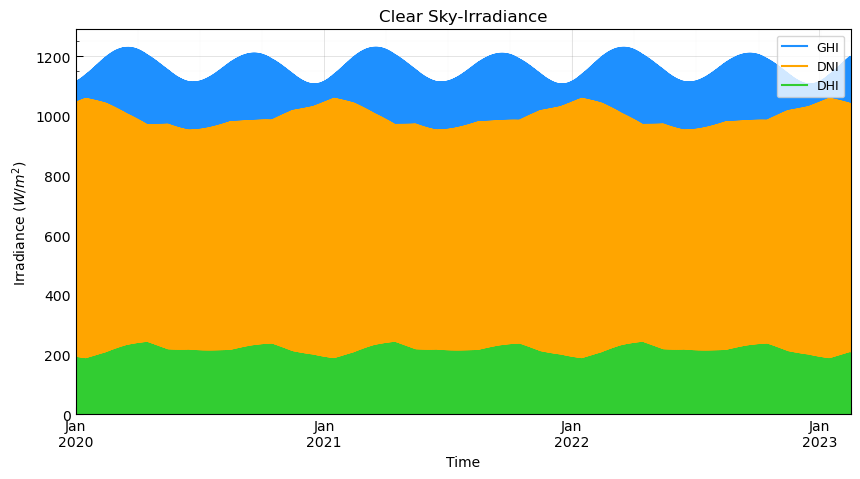

In [6]:
hor = 10
ver = 5
plt.figure(figsize=(hor, ver))

hcs['ghi'].plot(color='dodgerblue', label='GHI') # Global horizontal irradiance
hcs['dni'].plot(color='orange', label='DNI') # Direct normal irradiance
hcs['dhi'].plot(color='limegreen', label='DHI') # Diffuse horizontal irradiance

plt.rcParams['axes.axisbelow'] = True

plt.title('Clear Sky-Irradiance')
plt.ylabel('Irradiance ($W/m^2$)')
plt.xlabel('Time')

plt.tick_params(which='major', direction='in', length=5, width=0.75, grid_alpha=0.3)
plt.tick_params(which='minor', direction='in', length=2.5, width=0.5, grid_alpha=0.3)
plt.xticks(rotation=0)
plt.minorticks_on()
plt.ylim(0, None)
plt.xlim(None, None)
plt.grid(True)
plt.grid(visible=True, which='major', color='grey', linestyle='-', linewidth=0.5)
plt.grid(visible=True, which='minor', color='lightgrey', linestyle='-', linewidth=0.3, alpha=0.2)
plt.legend(loc='upper right', fontsize=9)
plt.tight_layout;

Same as (**Bright et al., 2021**) described, at sunrise and sunset the values of irradiance are in the order of 0 - 10 W/m2, $k_c$ become very sensitive to discrepancies between clear-sky estimate and measurement. It is common in solar energy engineering to ignore the first 5° of solar elevation.

In [7]:
# Append clear-sky irradiance to main dataframe
df['hcs_wm2'] = hcs['ghi'].values

# Clear-sky index (kc) to main dataframe
df['kc'] = df['poa_wm2'].values / df['hcs_wm2'].values

# Filters
## NaN
df['kc'] = df['kc'].fillna(1)

# Replace kc > 1
df.loc[df['kc'] > 1, 'kc'] = 1

df.head()

,ghi_wm2,poa_wm2,hcs_wm2,kc
timestamp,,,,
2020-01-01 00:00:00,0.0,0.0,0.0,1.0
2020-01-01 00:05:00,0.0,0.0,0.0,1.0
2020-01-01 00:10:00,0.0,0.0,0.0,1.0
2020-01-01 00:15:00,0.0,0.0,0.0,1.0
2020-01-01 00:20:00,0.0,0.0,0.0,1.0


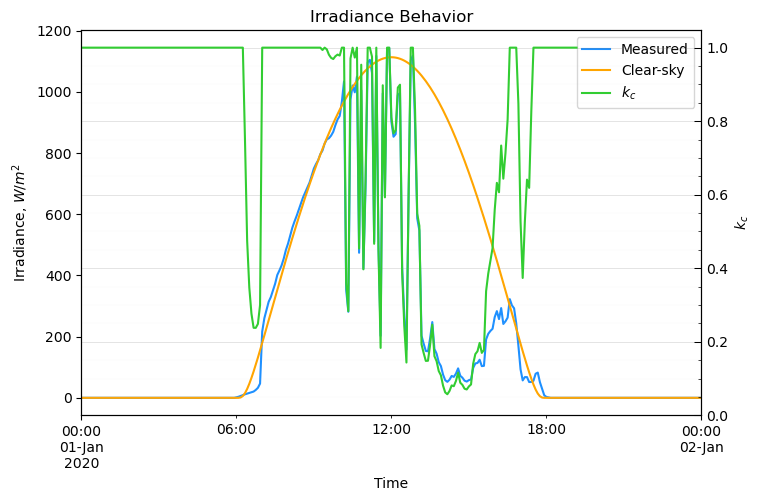

In [8]:
hor = 8
ver = 5
plt.figure(figsize=(hor, ver), dpi=100)

df['poa_wm2'][0:289].plot(color='dodgerblue', label='Measured', xlabel='Time', ylabel='Irradiance, $W/m^2$', legend=True)
df['hcs_wm2'][0:289].plot(color='orange', label='Clear-sky', xlabel='Time', ylabel='Irradiance, $W/m^2$', legend=True)
df['kc'][0:231].plot(color='limegreen', label='$k_c$', secondary_y=True, xlabel='Time', ylabel='$k_c$', legend=True, mark_right=False)

plt.rcParams['axes.axisbelow'] = True

plt.title('Irradiance Behavior')
plt.xlabel('Time')

plt.tick_params(which='major', direction='in', length=5, width=0.75, grid_alpha=0.3)
plt.tick_params(which='minor', direction='in', length=2.5, width=0.5, grid_alpha=0.3)
plt.xticks(rotation=0)
plt.minorticks_on()
plt.ylim(0, None)
plt.xlim(None, None)
plt.grid(True)
plt.grid(visible=True, which='major', color='grey', linestyle='-', linewidth=0.5)
plt.grid(visible=True, which='minor', color='lightgrey', linestyle='-', linewidth=0.3, alpha=0.2)
#plt.legend(loc='best', fontsize=9)
plt.tight_layout;

## 2.2. `analysis`: Function to extract descriptive statistics from irradiance data

In [9]:
TIMES = [f'{i}:0{j}' if j < 10 else f'{i}:{j}' for i in range(0, 24) for j in range(0, 60, 5)]

MONTHS = {'1': 'Jan', '2': 'Feb', '3': 'Mar', '4': 'Apr', '5': 'May', '6': 'Jun',
          '7': 'Jul', '8': 'Aug', '9': 'Sep', '10': 'Oct', '11': 'Nov', '12': 'Dec'}

INVERSE_MONTHS = {'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6,
                  'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12}

MULTIINDEX = [(i,j) for i in range(0, 24) for j in range(0, 60, 5)]

XTICKS = np.arange(start=0, stop=300, step=50)
LABELS = [TIMES[i] for i in XTICKS]

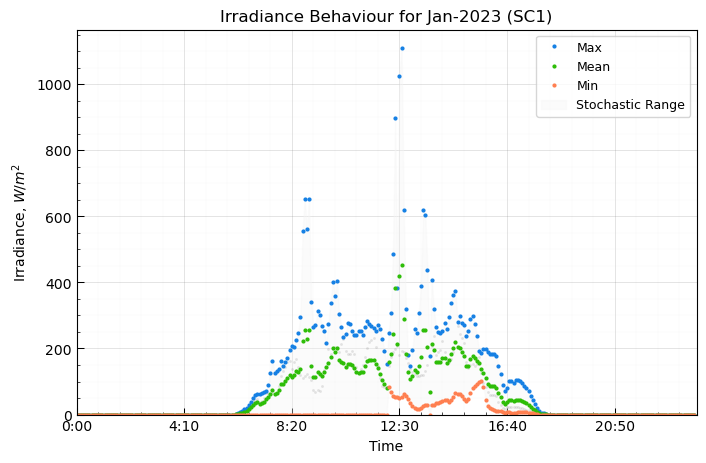

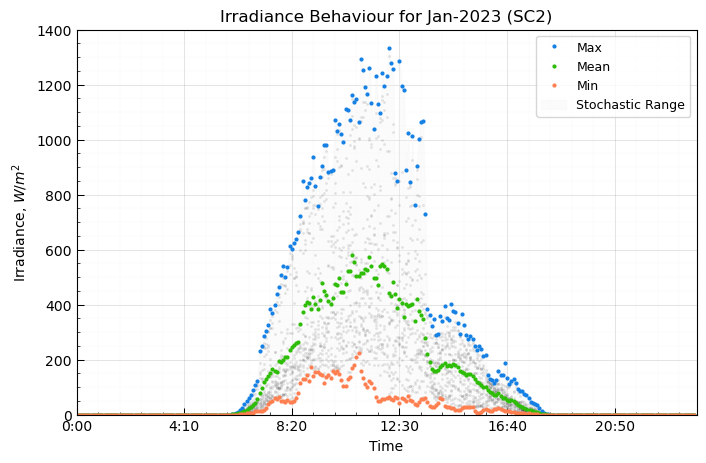

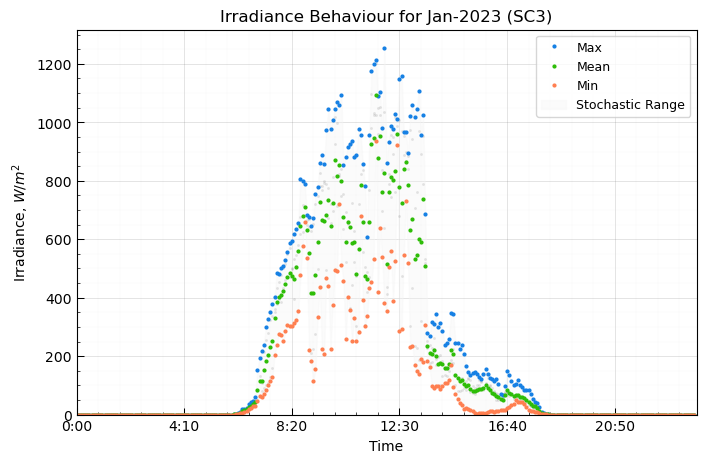

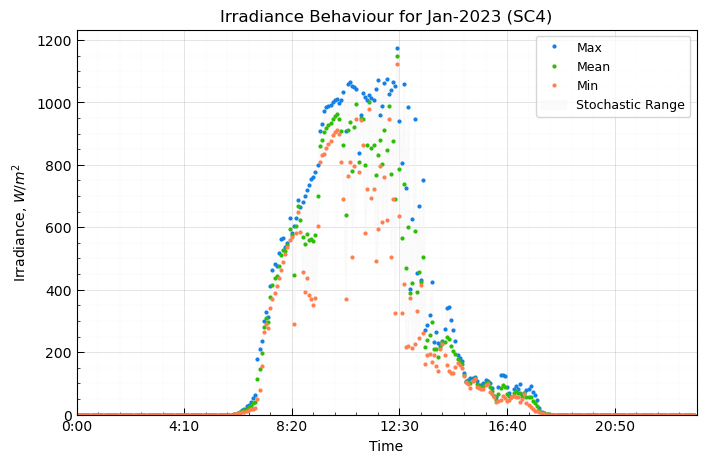

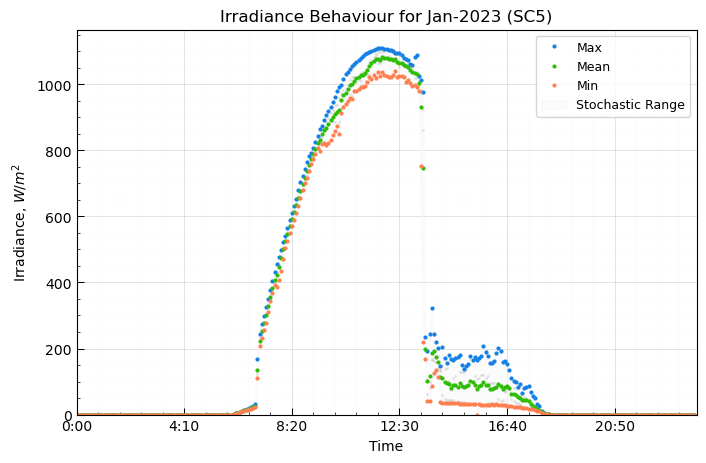

In [10]:
'''
irrad_analysis function example: analysing Jan-2021 data
'''
#Selecting year and month to extract
YEAR = 2023
MONTH = 1

ANALYSIS = src.utils.analysis(df=df, year=YEAR, month=MONTH, irradiance_column='poa_wm2', plot=True)

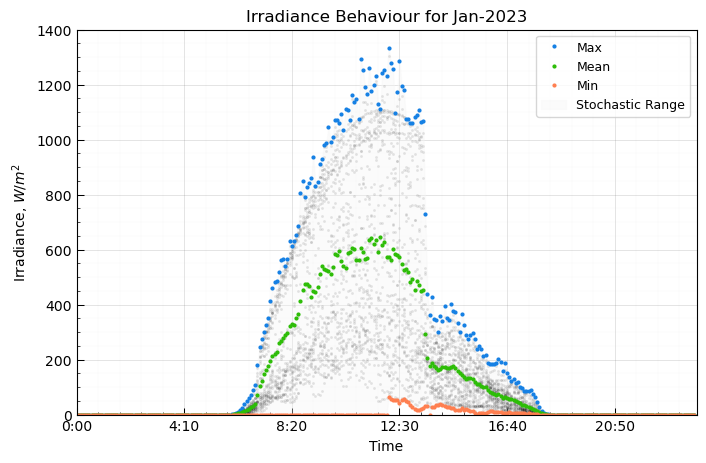

In [11]:
# Array list to store daily irradiance values from irrad_range
aux_irradiance = {'stochastic': {}, 'bootstrap': {}}

# Constants
TIMES = [f'{i}:0{j}' if j < 10 else f'{i}:{j}' for i in range(0, 24) for j in range(0, 60, 5)]

MONTHS = {'1': 'Jan', '2': 'Feb', '3': 'Mar', '4': 'Apr', '5': 'May', '6': 'Jun',
          '7': 'Jul', '8': 'Aug', '9': 'Sep', '10': 'Oct', '11': 'Nov', '12': 'Dec'}

# DataFrame filtered by date and between 6:00 to 18:00h range
data = df.loc[(df.index.year == YEAR) & (df.index.month == MONTH)]
aux_data = data.groupby([data.index.hour, data.index.minute])['poa_wm2'].describe()

XTICKS = np.arange(start=0, stop=300, step=50)
LABELS = [TIMES[i] for i in XTICKS]

hor = 8
ver = 5
plt.figure(figsize=(hor,ver))

plt.plot(pd.DataFrame(data['poa_wm2'].values.reshape(31, 288)).T.values, color='black', alpha=0.1, linestyle='', marker='.', markersize=2, fillstyle='none')

plt.plot(aux_data['max'].values, color='#1580E4', marker='.', markersize=4, linestyle='', label='Max')
plt.plot(aux_data['mean'].values, color='#2DBD07', marker='.', markersize=4, linestyle='', label='Mean')
plt.plot(aux_data['min'].values, color='coral', marker='.', markersize=4, linestyle='', label='Min')

plt.fill_between(x=np.arange(len(aux_data)), y1=aux_data['max'], y2=aux_data['min'], color='whitesmoke', alpha=0.35, label='Stochastic Range')

plt.title(f'Irradiance Behaviour for {MONTHS[str(MONTH)]}-{YEAR}')
plt.ylabel('Irradiance, $W/m^2$')
plt.xlabel('Time')

plt.tick_params(which='major', direction='in', length=5, width=0.75, grid_alpha=0.3)
plt.tick_params(which='minor', direction='in', length=2.5, width=0.5, grid_alpha=0.3)
plt.xticks(rotation=0, ticks=XTICKS, labels=LABELS)
plt.minorticks_on()
plt.ylim(0, None)
plt.xlim(0, len(aux_data))
plt.grid(True)
plt.grid(visible=True, which='major', color='grey', linestyle='-', linewidth=0.5)
plt.grid(visible=True, which='minor', color='lightgrey', linestyle='-', linewidth=0.3, alpha=0.2)
plt.tight_layout
plt.legend(loc='best', fontsize=9) # bbox_to_anchor=(1,1)

### 2.2.1. Histogram (Gaussian or lognormal distributions)

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

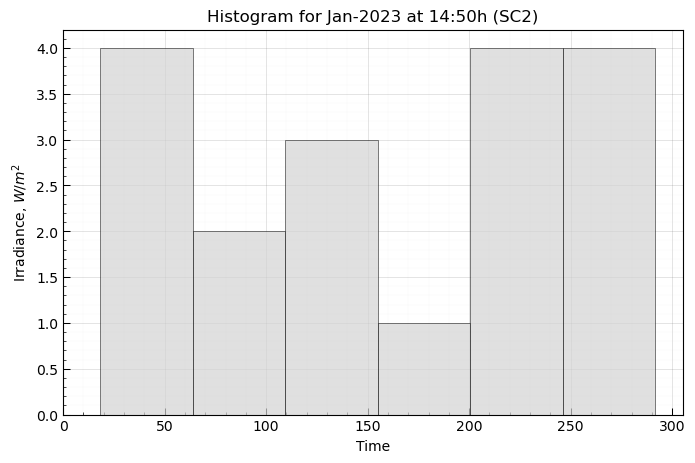

In [12]:
HOUR = 14
MINUTE = 50
SC = 'sc2'

df_to_hist = df[(df.index.year == YEAR) & (df.index.month == MONTH) & (df.index.day.isin(ANALYSIS['bootstrap'][SC].index)) & (df.index.hour == HOUR) & (df.index.minute == MINUTE)]['poa_wm2'].values

hor = 8
ver = 5
plt.figure(figsize=(hor,ver))

plt.hist(x=df_to_hist, bins='auto', color='lightgrey', alpha=0.7, edgecolor='black', linewidth=0.5);

plt.title(f'Histogram for {MONTHS[str(MONTH)]}-{YEAR} at {HOUR}:{MINUTE}h ({str.upper(SC)})')
plt.ylabel('Irradiance, $W/m^2$')
plt.xlabel('Time')
plt.tick_params(which='major', direction='in', length=5, width=0.75, grid_alpha=0.3)
plt.tick_params(which='minor', direction='in', length=2.5, width=0.5, grid_alpha=0.3)
plt.xticks(rotation=0)
plt.minorticks_on()
plt.ylim(0, None)
plt.xlim(0, None)
plt.grid(True)
plt.grid(visible=True, which='major', color='grey', linestyle='-', linewidth=0.5)
plt.grid(visible=True, which='minor', color='lightgrey', linestyle='-', linewidth=0.3, alpha=0.2)
plt.tight_layout
#plt.legend(loc='best', fontsize=9) # bbox_to_anchor=(1,1)

### 2.2.2. QQ-Plots

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

<Figure size 800x500 with 0 Axes>

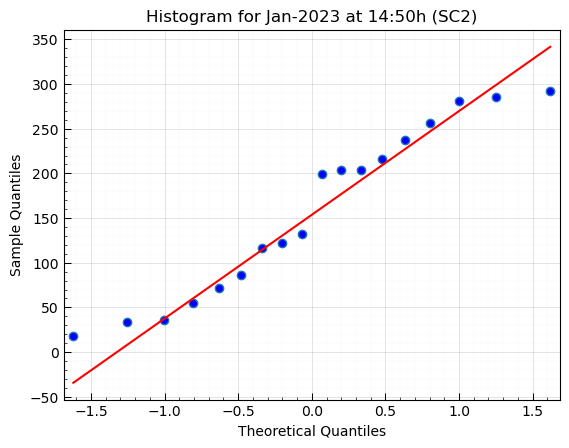

In [13]:
hor = 8
ver = 5
plt.figure(figsize=(hor,ver))

qqplot(df_to_hist, line='q', markerfacecolor='blue')

plt.title(f'Histogram for {MONTHS[str(MONTH)]}-{YEAR} at {HOUR}:{MINUTE}h ({str.upper(SC)})')
#plt.ylabel()
#plt.xlabel()
plt.tick_params(which='major', direction='in', length=5, width=0.75, grid_alpha=0.3)
plt.tick_params(which='minor', direction='in', length=2.5, width=0.5, grid_alpha=0.3)
plt.xticks(rotation=0)
plt.minorticks_on()
plt.ylim(None, None)
plt.xlim(None, None)
plt.grid(True)
plt.grid(visible=True, which='major', color='grey', linestyle='-', linewidth=0.5)
plt.grid(visible=True, which='minor', color='lightgrey', linestyle='-', linewidth=0.3, alpha=0.2)
plt.tight_layout
#plt.legend(loc='best', fontsize=9) # bbox_to_anchor=(1,1)

## 2.3. Method 1: `stochastic`

### 2.3.1. Synthetic solar irradiance

In [14]:
# stochastic synthetic irradiance for Jan-2021 data
SC = 'sc5'
RUNS = 5

test_stochastic = src.methods.stochastic(dictionary=ANALYSIS['stochastic'], year=YEAR, month=MONTH, sky_condition=SC, runs=RUNS)

<Figure size 1000x500 with 0 Axes>

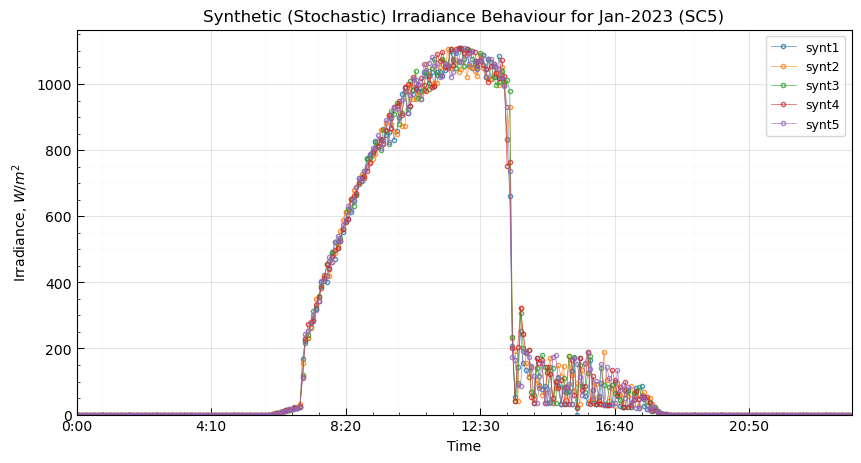

In [15]:
hor = 10
ver = 5
plt.figure(figsize=(hor,ver))

test_stochastic[f'{MONTHS[str(MONTH)]}{YEAR}-{SC}'].plot(alpha=0.8, linewidth=0.5, linestyle='-', marker='.', fillstyle='none', figsize=(hor,ver), legend=True)

plt.title(f'Synthetic (Stochastic) Irradiance Behaviour for {MONTHS[str(MONTH)]}-{YEAR} ({str.upper(SC)})')
plt.ylabel('Irradiance, $W/m^2$')
plt.xlabel('Time')
plt.tick_params(which='major', direction='in', length=5, width=0.75, grid_alpha=0.3)
plt.tick_params(which='minor', direction='in', length=2.5, width=0.5, grid_alpha=0.3)
plt.xticks(rotation=0, ticks=XTICKS, labels=LABELS)
plt.minorticks_on()
plt.ylim(0, None)
plt.xlim(0, len(test_stochastic[f'{MONTHS[str(MONTH)]}{YEAR}-{SC}']))
plt.grid(True)
plt.grid(visible=True, which='major', color='grey', linestyle='-', linewidth=0.5)
plt.grid(visible=True, which='minor', color='lightgrey', linestyle='-', linewidth=0.3, alpha=0.2)
plt.tight_layout
plt.legend(loc='best', fontsize=9) # bbox_to_anchor=(1,1)

## 2.4. Method 2: `bootstrap`

### 2.4.1. Synthetic solar irradiance

In [16]:
# bootstrap synthetic irradiance for Jan-2021 data.
SC = 'sc5'
RUNS = 5

test_bootstrap = src.methods.bootstrap(dictionary=ANALYSIS['bootstrap'], year=YEAR, month=MONTH, sky_condition=SC, runs=RUNS)

<Figure size 1000x500 with 0 Axes>

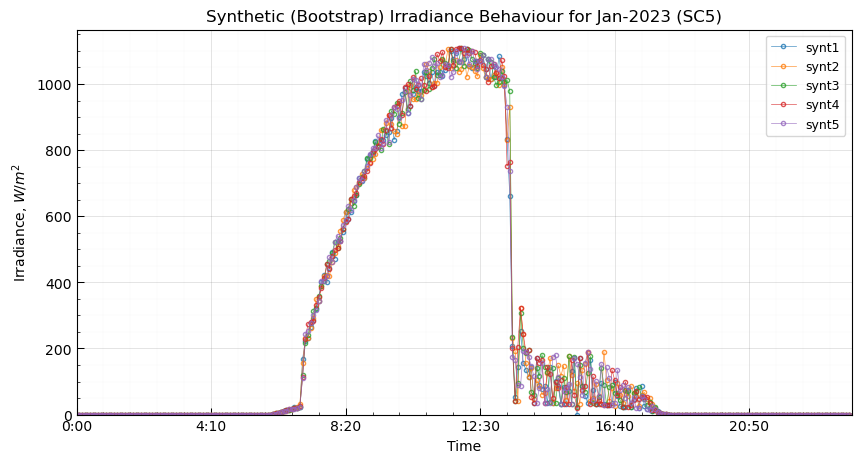

In [17]:
hor = 10
ver = 5
plt.figure(figsize=(hor,ver))

test_stochastic[f'{MONTHS[str(MONTH)]}{YEAR}-{SC}'].plot(alpha=0.8, linewidth=0.5, linestyle='-', marker='.', fillstyle='none', figsize=(hor,ver), legend=True)

plt.title(f'Synthetic (Bootstrap) Irradiance Behaviour for {MONTHS[str(MONTH)]}-{YEAR} ({str.upper(SC)})')
plt.ylabel('Irradiance, $W/m^2$')
plt.xlabel('Time')
plt.tick_params(which='major', direction='in', length=5, width=0.75, grid_alpha=0.3)
plt.tick_params(which='minor', direction='in', length=2.5, width=0.5, grid_alpha=0.3)
plt.xticks(rotation=0, ticks=XTICKS, labels=LABELS)
plt.minorticks_on()
plt.ylim(0, None)
plt.xlim(0, len(test_stochastic[f'{MONTHS[str(MONTH)]}{YEAR}-{SC}']))
plt.grid(True)
plt.grid(visible=True, which='major', color='grey', linestyle='-', linewidth=0.5)
plt.grid(visible=True, which='minor', color='lightgrey', linestyle='-', linewidth=0.3, alpha=0.2)
plt.tight_layout
plt.legend(loc='best', fontsize=9) # bbox_to_anchor=(1,1)

## 2.5. Method 3: `autoregressive`

In [18]:
SC = 'sc5'
IC = 0.95

In [19]:
test_autoregressive_stochastic = src.methods.autoregressive(data=df,
                                                            irradiance_column='poa_wm2',
                                                            year=YEAR,
                                                            month=1,
                                                            sky_condition=SC,
                                                            method='stochastic',
                                                            IC=IC,
                                                            runs=RUNS)

test_autoregressive_stochastic.head()

synt1  synt2  synt3  synt4  synt5
hour minute                                   
0    0         0.0    0.0    0.0    0.0    0.0
     5         0.0    0.0    0.0    0.0    0.0
     10        0.0    0.0    0.0    0.0    0.0
     15        0.0    0.0    0.0    0.0    0.0
     20        0.0    0.0    0.0    0.0    0.0

In [20]:
test_autoregressive_bootstrap = src.methods.autoregressive(data=df,
                                                           irradiance_column='poa_wm2',
                                                           year=YEAR,
                                                           month=1,
                                                           sky_condition=SC,
                                                           method='bootstrap',
                                                           IC=IC,
                                                           runs=RUNS)

test_autoregressive_bootstrap.head()

synt1  synt2  synt3  synt4  synt5
hour minute                                   
0    0         0.0    0.0    0.0    0.0    0.0
     5         0.0    0.0    0.0    0.0    0.0
     10        0.0    0.0    0.0    0.0    0.0
     15        0.0    0.0    0.0    0.0    0.0
     20        0.0    0.0    0.0    0.0    0.0

<Figure size 800x500 with 0 Axes>

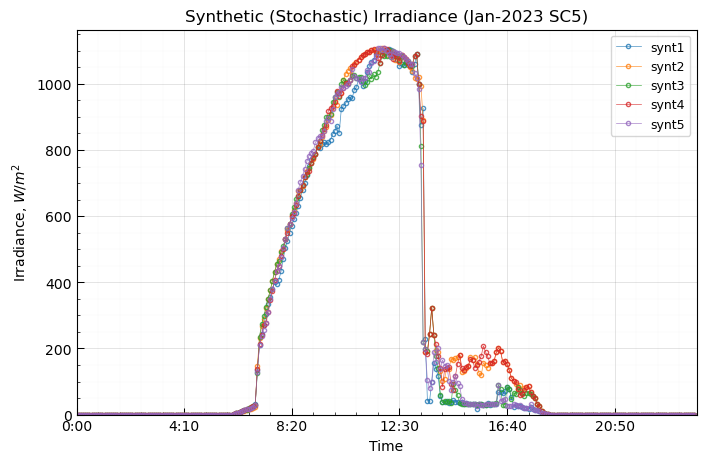

In [21]:
hor = 8
ver = 5
plt.figure(figsize=(hor,ver))

test_autoregressive_stochastic.plot(alpha=0.8, linewidth=0.5, linestyle='-', marker='.', fillstyle='none', figsize=(hor,ver), legend=True)

plt.title(f'Synthetic (Stochastic) Irradiance ({MONTHS[str(MONTH)]}-{YEAR} {str.upper(SC)})')
plt.ylabel('Irradiance, $W/m^2$')
plt.xlabel('Time')
plt.tick_params(which='major', direction='in', length=5, width=0.75, grid_alpha=0.3)
plt.tick_params(which='minor', direction='in', length=2.5, width=0.5, grid_alpha=0.3)
plt.xticks(rotation=0, ticks=XTICKS, labels=LABELS)
plt.minorticks_on()
plt.ylim(0, None)
plt.xlim(0, len(test_autoregressive_stochastic))
plt.grid(True)
plt.grid(visible=True, which='major', color='grey', linestyle='-', linewidth=0.5)
plt.grid(visible=True, which='minor', color='lightgrey', linestyle='-', linewidth=0.3, alpha=0.2)
plt.tight_layout
plt.legend(loc='best', fontsize=9) # bbox_to_anchor=(1,1)

<Figure size 800x500 with 0 Axes>

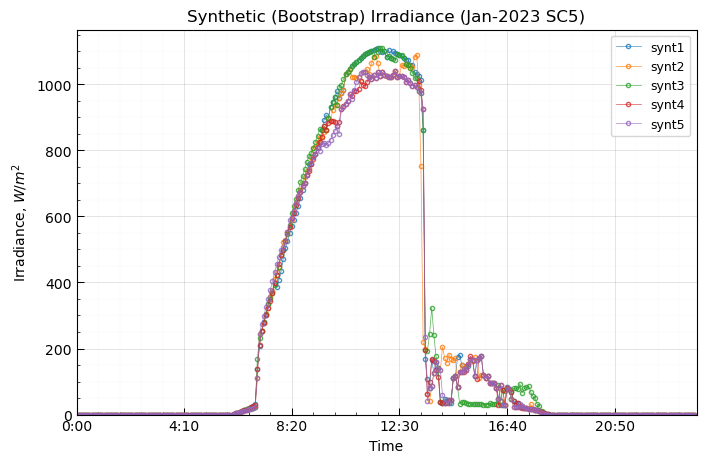

In [22]:
hor = 8
ver = 5
plt.figure(figsize=(hor,ver))

test_autoregressive_bootstrap.plot(alpha=0.8, linewidth=0.5, linestyle='-', marker='.', fillstyle='none', figsize=(hor,ver), legend=True)

plt.title(f'Synthetic (Bootstrap) Irradiance ({MONTHS[str(MONTH)]}-{YEAR} {str.upper(SC)})')
plt.ylabel('Irradiance, $W/m^2$')
plt.xlabel('Time')
plt.tick_params(which='major', direction='in', length=5, width=0.75, grid_alpha=0.3)
plt.tick_params(which='minor', direction='in', length=2.5, width=0.5, grid_alpha=0.3)
plt.xticks(rotation=0, ticks=XTICKS, labels=LABELS)
plt.minorticks_on()
plt.ylim(0, None)
plt.xlim(0, len(test_autoregressive_bootstrap))
plt.grid(True)
plt.grid(visible=True, which='major', color='grey', linestyle='-', linewidth=0.5)
plt.grid(visible=True, which='minor', color='lightgrey', linestyle='-', linewidth=0.3, alpha=0.2)
plt.tight_layout
plt.legend(loc='best', fontsize=9) # bbox_to_anchor=(1,1)

# 3. Validations

In [23]:
LOOP_YEARS = df.index.year.unique().values
LOOP_MONTHS = df.index.month.unique().values
LOOP_SC = ['sc1', 'sc2', 'sc3', 'sc4', 'sc5']

IC = 0.95
RUNS = 5

In [24]:
LOOP_ANALYSIS = {}

for i in LOOP_YEARS:
    for j in LOOP_MONTHS:
        LOOP_ANALYSIS[f'{MONTHS[str(j)]}{i}'] = src.utils.analysis(df=df, year=i, month=j, irradiance_column='poa_wm2', plot=False)

In [25]:
SYNTHETIC = {'stochastic': {}, 'bootstrap': {}}

for i in LOOP_YEARS:
    for j in LOOP_MONTHS:
        for k in LOOP_SC:
            # Stochastic
            SYNTHETIC['stochastic'][f'{MONTHS[str(j)]}{i}-{k}'] = src.methods.autoregressive(data=df,
                                                                                             irradiance_column='poa_wm2',
                                                                                             year=i,
                                                                                             month=j,
                                                                                             sky_condition=k,
                                                                                             method='stochastic',
                                                                                             IC=IC,
                                                                                             runs=RUNS)
            # Bootstrap
            SYNTHETIC['bootstrap'][f'{MONTHS[str(j)]}{i}-{k}'] = src.methods.autoregressive(data=df,
                                                                                            irradiance_column='poa_wm2',
                                                                                            year=i,
                                                                                            month=j,
                                                                                            sky_condition=k,
                                                                                            method='bootstrap',
                                                                                            IC=IC,
                                                                                            runs=RUNS)

## 3.1. Variability metrics

In [26]:
VARIABILITY_METRICS = {'stochastic': {}, 'bootstrap': {}}
RUNS = 5

for m in ['stochastic', 'bootstrap']:
    for z in SYNTHETIC[m].keys():
        i = int(z[3:7]) # Year
        j = INVERSE_MONTHS[z[0:3]] # Month
        k = z[8:11] # Sky condition

        metrics = {'standard_deviation_increments': [[], []],
                    'stability_index': [[], []],
                    'iccdf': [[], []],
                    'variability_index': [[], []]}

        for _ in range(RUNS):
            try:
                aux = LOOP_ANALYSIS[f'{MONTHS[str(j)]}{i}']['bootstrap'][k].T.sample(n=1, axis=1)
                sample1 = aux.values.flatten()
                sample2 = SYNTHETIC[m][f'{MONTHS[str(j)]}{i}-{k}'].sample(n=1, axis=1).values.flatten()

                # Standard deviation of increments (SDI)
                metrics['standard_deviation_increments'][0].append(src.metrics.standard_deviation_increments(data=sample1))
                metrics['standard_deviation_increments'][1].append(src.metrics.standard_deviation_increments(data=sample2))

                # Stability index (SI)
                metrics['stability_index'][0].append(src.metrics.stability_index(data=sample1, threshold=100))
                metrics['stability_index'][1].append(src.metrics.stability_index(data=sample2, threshold=100))

                # Integrated complementary cumulative distribution function (ICCDF)
                metrics['iccdf'][0].append(src.metrics.iccdf(data=sample1))
                metrics['iccdf'][1].append(src.metrics.iccdf(data=sample2))

                # Variability index (VI)
                temp = df.loc[(df.index.year == i) & (df.index.month == j) & (df.index.day == aux.columns[0])]
                metrics['variability_index'][0].append(src.metrics.variability_index(timestamps=temp.index, ghi=sample1, hcs=temp['hcs_wm2'].values).mean())
                metrics['variability_index'][1].append(src.metrics.variability_index(timestamps=temp.index, ghi=sample2, hcs=temp['hcs_wm2'].values).mean())

            except:
                pass

        for _ in metrics.keys():
            metrics[_] = np.mean(metrics[_], axis=1)

        VARIABILITY_METRICS[m][f'{MONTHS[str(j)]}{i}-{k}'] = metrics

In [27]:
metrics_stochastic = pd.DataFrame(VARIABILITY_METRICS['stochastic']).T
metrics_bootstrap = pd.DataFrame(VARIABILITY_METRICS['bootstrap']).T

# Stochastic
pe_stochastic = metrics_stochastic * 0

pe_stochastic['month'] = [INVERSE_MONTHS[i[0:3]] for i in pe_stochastic.index]
pe_stochastic['sc'] = [i[8:11] for i in pe_stochastic.index]

for i in metrics_stochastic.columns:
    pe_stochastic[i] = [src.metrics.wrapper_percentage_error(j) for j in metrics_stochastic[i]]

pe_stochastic = pe_stochastic.fillna(0)

# Bootstrap
pe_bootstrap = metrics_bootstrap * 0

pe_bootstrap['month'] = [INVERSE_MONTHS[i[0:3]] for i in pe_bootstrap.index]
pe_bootstrap['sc'] = [i[8:11] for i in pe_bootstrap.index]

for i in metrics_bootstrap.columns:
    pe_bootstrap[i] = [src.metrics.wrapper_percentage_error(j) for j in metrics_bootstrap[i]]

pe_bootstrap = pe_bootstrap.fillna(0)

In [28]:
# Percentage error monthly average
VM_STOCHASTIC_MONTH = pe_stochastic.groupby(by='month').mean().round(decimals=2)
VM_BOOTSTRAP_MONTH = pe_bootstrap.groupby(by='month').mean().round(decimals=2)

# Percentage error sky condition average
VM_STOCHASTIC_SC = pe_stochastic.groupby(by='sc').mean().round(decimals=2)
VM_BOOTSTRAP_SC = pe_bootstrap.groupby(by='sc').mean().round(decimals=2)

In [29]:
# Download
VM_STOCHASTIC_MONTH.to_csv('./metrics/variability/stochastic_month.csv')
VM_BOOTSTRAP_MONTH.to_csv('./metrics/variability/bootstrap_month.csv')
VM_STOCHASTIC_SC.to_csv('./metrics/variability/stochastic_sc.csv')
VM_BOOTSTRAP_SC.to_csv('./metrics/variability/bootstrap_sc.csv')

In [30]:
VM_STOCHASTIC_MONTH.describe()

,standard_deviation_increments,stability_index,iccdf,variability_index
count,12.000000,12.0,12.000000,12.000000
mean,7.965833,0.0,12.568333,6.747500
std,4.903710,0.0,23.054448,3.871948
min,2.530000,0.0,2.880000,1.660000
25%,5.215000,0.0,3.860000,4.292500
50%,6.705000,0.0,4.415000,5.605000
75%,10.385000,0.0,7.432500,9.500000
max,20.130000,0.0,84.480000,14.360000


In [31]:
VM_BOOTSTRAP_MONTH.describe()

,standard_deviation_increments,stability_index,iccdf,variability_index
count,12.000000,12.0,12.000000,12.000000
mean,8.292500,0.0,3.030833,7.745833
std,3.636872,0.0,4.072213,3.908402
min,2.610000,0.0,-8.240000,2.130000
25%,6.480000,0.0,2.302500,5.427500
50%,7.860000,0.0,3.625000,6.705000
75%,11.807500,0.0,4.682500,10.132500
max,13.370000,0.0,8.150000,13.980000


In [32]:
VM_STOCHASTIC_SC.describe()

,standard_deviation_increments,stability_index,iccdf,variability_index,month
count,5.000000,5.0,5.000000,5.000000,5.0
mean,7.968000,0.0,12.570000,6.746000,6.5
std,6.022402,0.0,18.472256,3.730098,0.0
min,1.950000,0.0,0.320000,1.910000,6.5
25%,4.220000,0.0,0.430000,4.580000,6.5
50%,5.290000,0.0,4.110000,6.450000,6.5
75%,11.930000,0.0,13.890000,9.740000,6.5
max,16.450000,0.0,44.100000,11.050000,6.5


In [33]:
VM_BOOTSTRAP_SC.describe()

,standard_deviation_increments,stability_index,iccdf,variability_index,month
count,5.000000,5.0,5.000000,5.000000,5.0
mean,8.292000,0.0,3.030000,7.746000,6.5
std,6.871235,0.0,4.632726,5.771727,0.0
min,0.290000,0.0,-0.310000,0.270000,6.5
25%,3.010000,0.0,0.060000,3.260000,6.5
50%,8.040000,0.0,0.620000,9.630000,6.5
75%,13.440000,0.0,4.070000,11.580000,6.5
max,16.680000,0.0,10.710000,13.990000,6.5


## 3.2. Comparison of statistical distributions

In [34]:
STATISTICAL_METRICS = {'stochastic': {}, 'bootstrap': {}}
RUNS = 5

for m in ['stochastic', 'bootstrap']:
    for z in SYNTHETIC[m].keys():
        i = int(z[3:7]) # Year
        j = INVERSE_MONTHS[z[0:3]] # Month
        k = z[8:11] # Sky condition

        metrics = {'kolmogorov_smirnov': [],
                   'kullback_leibler_divergence': [],
                   'overlapping_coefficient': []}

        for _ in range(RUNS):
            try:
                sample1 = LOOP_ANALYSIS[f'{MONTHS[str(j)]}{i}']['bootstrap'][k].T.sample(n=1, axis=1).values.flatten()
                sample2 = SYNTHETIC[m][f'{MONTHS[str(j)]}{i}-{k}'].sample(n=1, axis=1).values.flatten()

                # Kolmogorov-Smirnov Test (KS)
                metrics['kolmogorov_smirnov'].append(src.metrics.kolmogorov_smirnov(sample1=sample1, sample2=sample2))

                # Kullback-Leibler Divergence (KLD)
                metrics['kullback_leibler_divergence'].append(src.metrics.kullback_leibler_divergence(sample1=sample1, sample2=sample2))

                # Overlapping coefficient (OVC)
                metrics['overlapping_coefficient'].append(src.metrics.overlapping_coefficient(sample1=sample1, sample2=sample2))

            except:
                pass

        for _ in metrics.keys():
            metrics[_] = np.mean(metrics[_])

        STATISTICAL_METRICS[m][f'{MONTHS[str(j)]}{i}-{k}'] = metrics

In [35]:
ovc = pd.Series([STATISTICAL_METRICS['bootstrap'][i]['overlapping_coefficient'] for i in STATISTICAL_METRICS['bootstrap'].keys()])
ovc.describe()

count    133.000000
mean       0.813779
std        0.182190
min        0.000000
25%        0.784028
50%        0.802083
75%        0.863194
max        1.000000
dtype: float64

In [36]:
# Stochastic
metrics_stochastic = pd.DataFrame(STATISTICAL_METRICS['stochastic']).T
metrics_stochastic['month'] = [INVERSE_MONTHS[i[0:3]] for i in metrics_stochastic.index]
metrics_stochastic['sc'] = [i[8:11] for i in metrics_stochastic.index]
metrics_stochastic = metrics_stochastic.fillna(0)

# Bootstrap
metrics_bootstrap = pd.DataFrame(STATISTICAL_METRICS['bootstrap']).T
metrics_bootstrap['month'] = [INVERSE_MONTHS[i[0:3]] for i in metrics_bootstrap.index]
metrics_bootstrap['sc'] = [i[8:11] for i in metrics_bootstrap.index]
metrics_bootstrap = metrics_bootstrap.fillna(0)

In [37]:
# Monthly average
SM_STOCHASTIC_MONTH = metrics_stochastic.groupby(by='month').mean().round(decimals=2)
SM_BOOTSTRAP_MONTH = metrics_bootstrap.groupby(by='month').mean().round(decimals=2)

# Sky condition average
SM_STOCHASTIC_SC = metrics_stochastic.groupby(by='sc').mean().round(decimals=2)
SM_BOOTSTRAP_SC = metrics_bootstrap.groupby(by='sc').mean().round(decimals=2)

In [38]:
# Download
SM_STOCHASTIC_MONTH.to_csv('./metrics/statistical/stochastic_month.csv')
SM_BOOTSTRAP_MONTH.to_csv('./metrics/statistical/bootstrap_month.csv')
SM_STOCHASTIC_SC.to_csv('./metrics/statistical/stochastic_sc.csv')
SM_BOOTSTRAP_SC.to_csv('./metrics/statistical/bootstrap_sc.csv')

In [39]:
SM_STOCHASTIC_MONTH.describe()

,kolmogorov_smirnov,kullback_leibler_divergence,overlapping_coefficient
count,12.000000,12.0000,12.000000
mean,0.319167,0.1975,0.445000
std,0.086283,0.0791,0.129299
min,0.170000,0.1000,0.270000
25%,0.287500,0.1625,0.370000
50%,0.315000,0.1900,0.430000
75%,0.377500,0.2100,0.477500
max,0.460000,0.4000,0.690000


In [40]:
SM_BOOTSTRAP_MONTH.describe()

,kolmogorov_smirnov,kullback_leibler_divergence,overlapping_coefficient
count,12.000000,12.000000,12.000000
mean,0.342500,0.249167,0.449167
std,0.082696,0.094336,0.130137
min,0.210000,0.090000,0.280000
25%,0.287500,0.197500,0.370000
50%,0.335000,0.225000,0.435000
75%,0.395000,0.307500,0.485000
max,0.510000,0.420000,0.690000


In [41]:
SM_STOCHASTIC_SC.describe()

,kolmogorov_smirnov,kullback_leibler_divergence,overlapping_coefficient,month
count,5.000000,5.000000,5.000000,5.0
mean,0.318000,0.196000,0.444000,6.5
std,0.104259,0.148088,0.123004,0.0
min,0.190000,0.030000,0.260000,6.5
25%,0.240000,0.100000,0.380000,6.5
50%,0.320000,0.210000,0.490000,6.5
75%,0.410000,0.220000,0.540000,6.5
max,0.430000,0.420000,0.550000,6.5


In [42]:
SM_BOOTSTRAP_SC.describe()

,kolmogorov_smirnov,kullback_leibler_divergence,overlapping_coefficient,month
count,5.000000,5.00000,5.000000,5.0
mean,0.344000,0.25000,0.452000,6.5
std,0.103102,0.18262,0.128141,0.0
min,0.240000,0.02000,0.260000,6.5
25%,0.250000,0.13000,0.390000,6.5
50%,0.330000,0.27000,0.490000,6.5
75%,0.440000,0.34000,0.550000,6.5
max,0.460000,0.49000,0.570000,6.5


## 3.3. Energy production

In [43]:
INVERTER = pvlib.pvsystem.retrieve_sam(name='CECInverter')['ABB__TRIO_50_0_TL_OUTD_US_480__480V_']
MODULE = pvlib.pvsystem.retrieve_sam(name='CECMod')['LG_Electronics_Inc__LG400N2W_A5']
MPS = 16 # Modules per string
SPI = 8 # Strings per inverter
LOSS = 26.9

In [44]:
TEMP = pd.read_csv(filepath_or_buffer='./data/temperature.csv', sep=',', decimal='.', index_col='timestamp', parse_dates=True)
TEMP = TEMP.fillna(0)

TMOD = np.mean(TEMP['tmod_c'].loc[(TEMP.index.hour >= 6) & (TEMP.index.hour < 18)])


RESOLUTION = int(pd.Series(TEMP.index).diff().median().total_seconds()/60)

In [45]:
ENERGY_METRIC = {'stochastic': {}, 'bootstrap': {}}
RUNS = 5

for m in ['stochastic', 'bootstrap']:
    for z in SYNTHETIC[m].keys():
        i = int(z[3:7]) # Year
        j = INVERSE_MONTHS[z[0:3]] # Month
        k = z[8:11] # Sky condition

        metrics = [[], []]

        for _ in range(RUNS):
            try:
                sample1 = LOOP_ANALYSIS[f'{MONTHS[str(j)]}{i}']['bootstrap'][k].T.sample(n=1, axis=1).values.flatten()
                sample2 = SYNTHETIC[m][f'{MONTHS[str(j)]}{i}-{k}'].sample(n=1, axis=1).values.flatten()

                # Energy production
                metrics[0].append(src.metrics.energy(irradiance=sample1, resolution=RESOLUTION, tmod=TMOD, inverter=INVERTER, module=MODULE, mps=MPS, spi=SPI, loss=LOSS))
                metrics[1].append(src.metrics.energy(irradiance=sample2, resolution=RESOLUTION, tmod=TMOD, inverter=INVERTER, module=MODULE, mps=MPS, spi=SPI, loss=LOSS))

            except:
                pass

        ENERGY_METRIC[m][f'{MONTHS[str(j)]}{i}-{k}'] = np.mean(metrics, axis=1)

In [46]:
# Stochastic
metrics_stochastic = pd.DataFrame(ENERGY_METRIC['stochastic'], index=['real', 'synthetic']).T

metrics_stochastic['month'] = [INVERSE_MONTHS[i[0:3]] for i in metrics_stochastic.index]
metrics_stochastic['sc'] = [i[8:11] for i in metrics_stochastic.index]

metrics_stochastic['percentage_error'] = src.metrics.percentage_error(target=metrics_stochastic['real'], predicted=metrics_stochastic['synthetic'])

metrics_stochastic = metrics_stochastic.fillna(0)

# Bootstrap
metrics_bootstrap = pd.DataFrame(ENERGY_METRIC['bootstrap'], index=['real', 'synthetic']).T

metrics_bootstrap['month'] = [INVERSE_MONTHS[i[0:3]] for i in metrics_bootstrap.index]
metrics_bootstrap['sc'] = [i[8:11] for i in metrics_bootstrap.index]

metrics_bootstrap['percentage_error'] = src.metrics.percentage_error(target=metrics_bootstrap['real'], predicted=metrics_bootstrap['synthetic'])

metrics_bootstrap = metrics_bootstrap.fillna(0)

In [47]:
# Percentage error monthly average
EM_STOCHASTIC_MONTH = metrics_stochastic.groupby(by='month').mean().round(decimals=2)
EM_BOOTSTRAP_MONTH = metrics_bootstrap.groupby(by='month').mean().round(decimals=2)

# Percentage error sky condition average
EM_STOCHASTIC_SC = metrics_stochastic.groupby(by='sc').mean().round(decimals=2)
EM_BOOTSTRAP_SC = metrics_bootstrap.groupby(by='sc').mean().round(decimals=2)

In [48]:
# Download
EM_STOCHASTIC_MONTH.to_csv('./metrics/energy/stochastic_month.csv')
EM_BOOTSTRAP_MONTH.to_csv('./metrics/energy/bootstrap_month.csv')
EM_STOCHASTIC_SC.to_csv('./metrics/energy/stochastic_sc.csv')
EM_BOOTSTRAP_SC.to_csv('./metrics/energy/bootstrap_sc.csv')

In [49]:
EM_STOCHASTIC_MONTH.describe()

,real,synthetic,percentage_error
count,12.000000,12.000000,12.000000
mean,74432.537500,77331.184167,5.262500
std,25197.946089,26603.387972,2.878084
min,44033.980000,48803.220000,1.890000
25%,56841.030000,58708.567500,3.680000
50%,69357.485000,70871.565000,4.800000
75%,81723.262500,84395.272500,6.080000
max,123024.490000,131266.960000,12.390000


In [50]:
EM_BOOTSTRAP_MONTH.describe()

,real,synthetic,percentage_error
count,12.000000,12.000000,12.000000
mean,74296.367500,74707.987500,3.375833
std,24446.303304,25206.178257,1.840679
min,45500.970000,44369.550000,1.270000
25%,57236.605000,56698.232500,2.057500
50%,68913.810000,69437.100000,3.220000
75%,82061.887500,82466.207500,3.925000
max,122614.820000,124459.930000,8.160000


In [51]:
EM_STOCHASTIC_SC.describe()

,real,synthetic,month,percentage_error
count,5.000000,5.000000,5.0,5.000000
mean,74432.538000,77331.186000,6.5,5.262000
std,29563.737595,31599.131596,0.0,6.771032
min,37207.010000,35825.440000,6.5,0.160000
25%,52364.580000,52672.460000,6.5,0.510000
50%,80310.490000,91911.040000,6.5,2.710000
75%,92135.760000,95371.650000,6.5,6.400000
max,110144.850000,110875.340000,6.5,16.530000


In [52]:
EM_BOOTSTRAP_SC.describe()

,real,synthetic,month,percentage_error
count,5.000000,5.000000,5.0,5.000000
mean,74296.366000,74707.990000,6.5,3.378000
std,29408.184191,30316.808076,0.0,3.759371
min,37053.550000,35649.400000,6.5,0.100000
25%,52424.370000,52572.430000,6.5,0.590000
50%,80280.460000,82113.580000,6.5,3.050000
75%,92297.040000,92673.900000,6.5,3.620000
max,109426.410000,110530.640000,6.5,9.530000


# 4. $T_{amb}$ and $T_{mod}$ Synthetic Data Generation

## 4.1. Data

In [53]:
df = pd.merge(df, TEMP, on=['timestamp'])
df['noct_c'] = df['tamb_c'] + (((MODULE['T_NOCT'] - 20)/800) * df['poa_wm2'])

## 4.2. Method: `autoregressive`

In [54]:
SC = 'sc5'

SYNTHETIC_TAMB = {}
SYNTHETIC_TMOD = {}

for sc in ['sc1', 'sc2', 'sc3', 'sc4', 'sc5']:
    try:
        SYNTHETIC_TAMB[sc] = SYNTHETIC['bootstrap'][f'Jan2020-{sc}'] * 0
        SYNTHETIC_TMOD[sc] = SYNTHETIC['bootstrap'][f'Jan2020-{sc}'] * 0

        data = df.loc[(df.index.year == 2020) & (df.index.month == 1) & (df.index.day.isin(LOOP_ANALYSIS['Jan2020']['bootstrap'][sc].T.columns))]

        for s in SYNTHETIC['bootstrap'][f'Jan2020-{sc}'].columns:
            irradiance = SYNTHETIC['bootstrap'][f'Jan2020-{sc}'][s].values

            tamb = []
            tmod = []

            # Synthetic stochastic temperature
            for i in irradiance:
                irradiance_range = data.loc[(i - i*0.025 <= data['poa_wm2']) & (data['poa_wm2'] <= i + i*0.025)]

                synt_tamb = np.random.normal(loc=irradiance_range['tamb_c'].mean(), scale=irradiance_range['tamb_c'].std())
                synt_tmod = np.random.normal(loc=irradiance_range['tmod_c'].mean(), scale=irradiance_range['tmod_c'].std())

                tamb.append(synt_tamb)
                tmod.append(synt_tmod)

            # Filter synthetic ambient temperature
            new_tamb = []
            for i in range(len(tamb)):
                if math.isnan(tamb[i]) == False:
                    new_tamb.append(tamb[i])
                else:
                    # Previous temperature
                    c = 1
                    t_back = tamb[i-c]

                    while math.isnan(t_back) == True:
                        c += 1
                        t_back = tamb[i-c]

                    # Next temperature
                    c = 1
                    t_front = tamb[i+c]

                    while math.isnan(t_front) == True:
                        c += 1
                        t_front = tamb[i+c]

                    new_tamb.append(np.mean((t_back, t_front)))

            # Filter synthetic module temperature
            new_tmod = []
            for i in range(len(tmod)):
                if math.isnan(tmod[i]) == False:
                    new_tmod.append(tmod[i])
                else:
                    # Previous temperature
                    c = 1
                    t_back = tmod[i-c]

                    while math.isnan(t_back) == True:
                        c += 1
                        t_back = tmod[i-c]

                    # Next temperature
                    c = 1
                    t_front = tmod[i+c]

                    while math.isnan(t_front) == True:
                        c += 1
                        t_front = tmod[i+c]

                    new_tmod.append(np.mean((t_back, t_front)))

            SYNTHETIC_TAMB[sc][s] = tamb
            SYNTHETIC_TMOD[sc][s] = tmod

    except:
        SYNTHETIC_TAMB[sc] = None
        SYNTHETIC_TMOD[sc] = None

In [55]:
# Ambient temperature
synthetic_tamb = []
for i in SYNTHETIC_TAMB.keys():
    try:
        synthetic_tamb = np.concatenate((synthetic_tamb, SYNTHETIC_TAMB[i].to_numpy().T.flatten()))
    except:
        pass

# Module temperature
synthetic_tmod = []
for i in SYNTHETIC_TMOD.keys():
    try:
        synthetic_tmod = np.concatenate((synthetic_tmod, SYNTHETIC_TMOD[i].to_numpy().T.flatten()))
    except:
        pass

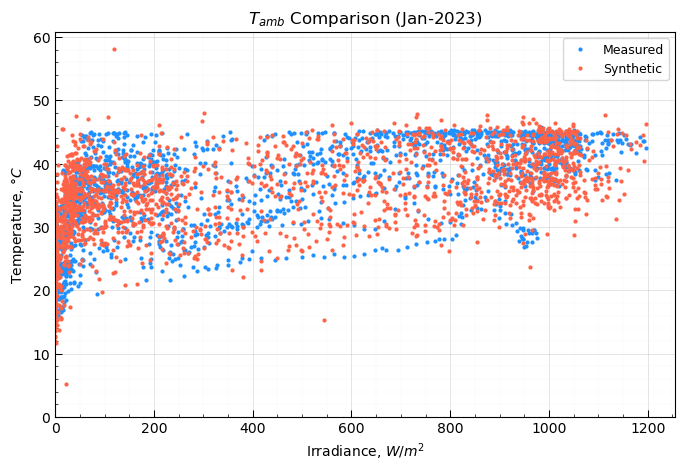

In [56]:
hor = 8
ver = 5
plt.figure(figsize=(hor,ver))

plt.plot(data['poa_wm2'].values, data['tamb_c'].values, linestyle='', marker='o', markerfacecolor='dodgerblue', markeredgecolor='dodgerblue', ms=2, label='Measured')
plt.plot(data['poa_wm2'].values, synthetic_tamb[0:len(data)], linestyle='', marker='o', markerfacecolor='tomato', markeredgecolor='tomato', ms=2, label='Synthetic')
#plt.plot(data['poa_wm2'].values, data['noct_c'].values, linestyle='', marker='o', markerfacecolor='orange', markeredgecolor='orange', ms=2, label='NOCT')

aux_str = '$T_{amb}$'
plt.title(f'{aux_str} Comparison ({MONTHS[str(MONTH)]}-{YEAR})')
plt.ylabel('Temperature, $°C$')
plt.xlabel('Irradiance, $W/m^2$')
plt.tick_params(which='major', direction='in', length=5, width=0.75, grid_alpha=0.3)
plt.tick_params(which='minor', direction='in', length=2.5, width=0.5, grid_alpha=0.3)
plt.xticks(rotation=0)
plt.minorticks_on()
plt.ylim(0, None)
plt.xlim(0, None)
plt.grid(True)
plt.grid(visible=True, which='major', color='grey', linestyle='-', linewidth=0.5)
plt.grid(visible=True, which='minor', color='lightgrey', linestyle='-', linewidth=0.3, alpha=0.2)
plt.tight_layout
plt.legend(loc='best', fontsize=9) # bbox_to_anchor=(1,1)

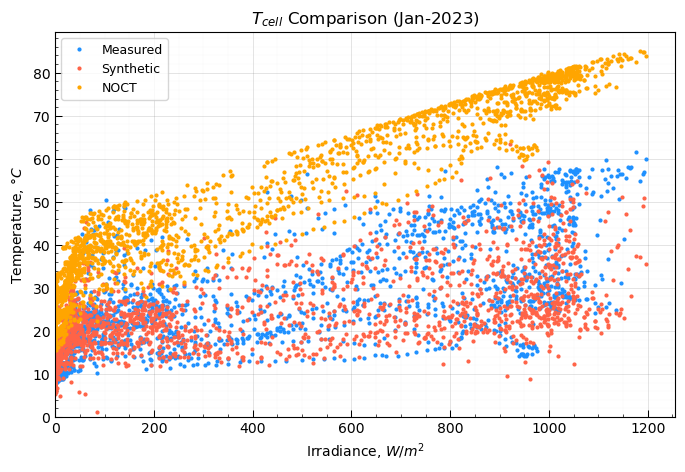

In [57]:
hor = 8
ver = 5
plt.figure(figsize=(hor,ver))

plt.plot(data['poa_wm2'].values, data['tmod_c'].values, linestyle='', marker='o', markerfacecolor='dodgerblue', markeredgecolor='dodgerblue', ms=2, label='Measured')
plt.plot(data['poa_wm2'].values, synthetic_tmod[0:len(data)], linestyle='', marker='o', markerfacecolor='tomato', markeredgecolor='tomato', ms=2, label='Synthetic')
plt.plot(data['poa_wm2'].values, data['noct_c'].values, linestyle='', marker='o', markerfacecolor='orange', markeredgecolor='orange', ms=2, label='NOCT')

aux_str = '$T_{cell}$'
plt.title(f'{aux_str} Comparison ({MONTHS[str(MONTH)]}-{YEAR})')
plt.ylabel('Temperature, $°C$')
plt.xlabel('Irradiance, $W/m^2$')
plt.tick_params(which='major', direction='in', length=5, width=0.75, grid_alpha=0.3)
plt.tick_params(which='minor', direction='in', length=2.5, width=0.5, grid_alpha=0.3)
plt.xticks(rotation=0)
plt.minorticks_on()
plt.ylim(0, None)
plt.xlim(0, None)
plt.grid(True)
plt.grid(visible=True, which='major', color='grey', linestyle='-', linewidth=0.5)
plt.grid(visible=True, which='minor', color='lightgrey', linestyle='-', linewidth=0.3, alpha=0.2)
plt.tight_layout
plt.legend(loc='best', fontsize=9) # bbox_to_anchor=(1,1)